# 医用画像処理の基本

本資料はメディカルAI学会公認資格講座における医用画像解析「放射線画像」のための<u>**非公認**</u>の補足資料です。

**深層畳み込みニューラルネットワークの基礎**についてソース・コードと共に解説します。

## 環境のセットアップ

### ライブラリのインストール

初めに、本補足資料において必要なPythonライブラリをインストールします。ライブラリは以下の通りです。

- **matplotlib** : 図表を可視化するためのライブラリ

In [0]:
!pip install matplotlib 

### サンプル画像のダウンロード

次のスクリプトを実行すると、Google colab上のホームディレクトリに`chest-xray.jpg`というファイル名でサンプル用の胸部X線写真がダウンロードされます。

注意：サンプル用のDICOM画像は以下のURLより取得したものを、Google colabからアクセス可能なGithub上のファイルとして配置し直したものです。

Chest radiograph - Wikipedia : https://en.wikipedia.org/wiki/Chest_radiograph

In [0]:
!curl -L -O https://github.com/Kaz-K/medical-ai-radiology/releases/download/v0.1/chest-xray.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   605    0   605    0     0   3457      0 --:--:-- --:--:-- --:--:--  3457
100  479k  100  479k    0     0   487k      0 --:--:-- --:--:-- --:--:--  787k


早速、画像ファイルを可視化して確認します。

画像ファイルをNumPy配列として読み込むことの出来る`imageio`を利用します。更に、元画像の解像度が`(2197, 1920)`と大きいため、以下の解説における計算時間を短縮する目的で、配列を画像として処理することの出来るライブラリ`scipy.ndimage`を用いてこれを0.5倍となる`(1098, 960)`に縮小します。

元画像の解像度:  (2197, 1920)
縮小後の解像度:  (1098, 960)


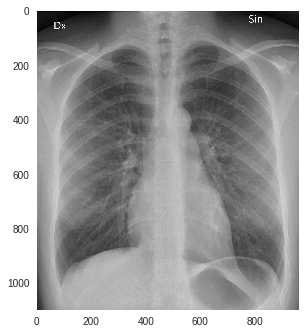

In [0]:
import imageio 
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
image = imageio.imread('chest-xray.jpg', pilmode='L')
print('元画像の解像度: ', image.shape)
image = scipy.ndimage.zoom(image, 0.5)
print('縮小後の解像度: ', image.shape)
ax.imshow(image, cmap='gray')
plt.grid(False)
plt.show()

## 畳み込み演算の基本

**畳み込み(Convolution)**とは、画像よりも小さなサイズを持つカーネル（あるいはフィルタ）と呼ばれる行列を用意し、画像の各画素に対してフィルタの中心を重ね、重なった領域全体に渡って画素とフィルタの内積を計算する演算を言います。

例えば、入力画像$x$の第$(i, j)$要素$x_{(i, j)}$に対して、$(2a+1) \times (2b+1)$の大きさを持つカーネル$w$を用いた畳み込みによって出力される$y_{(i, j)}$は次のように表されます。


$y_{i,j}=\sum_{s=-a}^{a} \sum_{t=-b}^{b}w_{(s,t)}x_{(i+sj,j+t)}$

これは、$x_{(i, j)}$を中心の画素として、行方向と列方向にそれぞれ$\pm a, \pm b$ずつ広げた画像中の少領域と、カーネル$w$の内積を$y_{(i,j)}$とすることを意味しています。

---
**注意** : `convolve2d`は以下のサイトからコードを借用していますが、他にも畳み込みの図式的な説明などもありますので参考にしてみて下さい。

参考 : http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html![image.png](attachment:image.png)

**注意** : より<u>厳密な</u>畳み込みの定義では、上式における$x$の添字が$x_{(i-s,j-t)}$となります。実際、深層畳み込みニューラルネットワークの文脈で語られる**畳み込み**は、数学的には**相関**であると指摘されています。

参考 : https://en.wikipedia.org/wiki/Kernel_(image_processing)

参考 : http://tdual.hatenablog.com/entry/2018/05/02/113110



### 畳み込み演算の実装

次の関数`convolve2d`はカーネルのサイズが$3 \times 3$の条件で、この数式の通りに画像に対する畳み込みを行うものになります。

In [0]:
def convolve2d(image, kernel):
    # 厳密な意味のconvolutionを計算する場合には次の一行をコメントアウトして用いる
    # kernel = np.flipud(np.fliplr(kernel))
    
    output = np.zeros_like(image).astype(np.float32)
    
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x, y] = (kernel * image_padded[x:x+3, y:y+3]).sum()        
    return output

以後、サンプル画像とその一部の少領域（以下、パッチ領域と呼びます）にそれぞれ注目し、個々のカーネルを用いた畳み込みによってどのように画像が変換されるのかを確認していきます。

まず、サンプル画像とそのパッチ領域を並べて表示するための関数を用意します。このとき、パッチ領域に対しては画素値に相当する数値を画像の上に重ねて表示させることで、それぞれの計算過程でピクセル値がどう変化するのかを確かめ易くすることとします。また、サンプル画像の上にパッチ領域に対応する部分を赤枠により表示します。

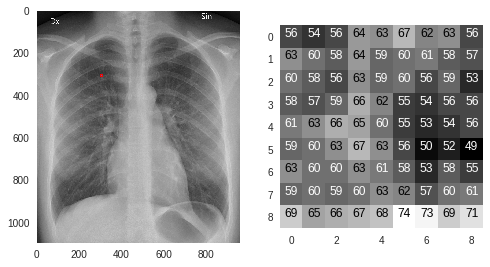

In [0]:
import matplotlib.patches as patches

def show_image_with_patch(image, x=300, y=300, width=9, height=9, vmin=0, vmax=255):
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.grid(False)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=None)
    ax.add_patch(rect)
    
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
   
    ax = fig.add_subplot(122)
    ax.grid(False)
    image_patch = image[x: x + width, y: y + height]
    ax.imshow(image_patch, cmap='gray')
    threshold = (image_patch.max() - image_patch.min()) / 2 + image_patch.min()
    for x in range(width):
        for y in range(height):
            val = int(image_patch[x][y])
            ax.annotate(str(val), 
                        xy=(y - 0.3, x), 
                        color='white' if image_patch[x][y] < threshold else 'black')
    plt.show()
    
show_image_with_patch(image)

### 各種の畳み込み演算の結果

続いて、各種の画像変換を行うためのカーネルを定め、実際にそれぞれの畳み込みを当てはめた際にどのように画像が変換されるのかを確かめます。名前のついたカーネルは数多くありますが、次のURLにその代表的なものが紹介されていますので、参考にして下さい。

参考URL : https://en.wikipedia.org/wiki/Kernel_(image_processing)

identity


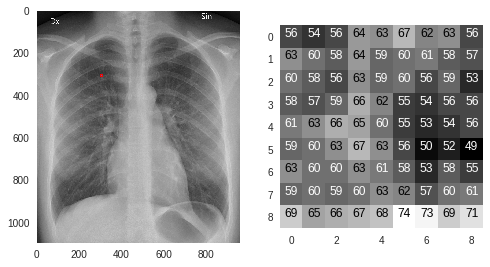

edge detection


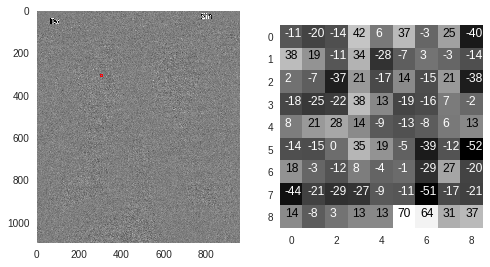

vertical edge detection


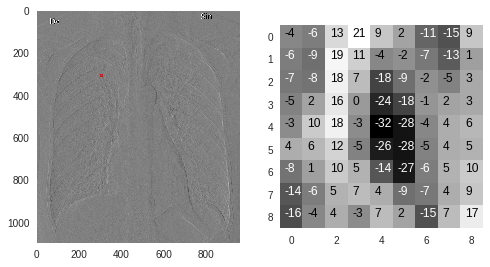

horizontal edge detection


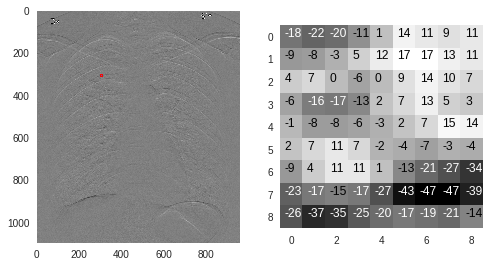

sharpen


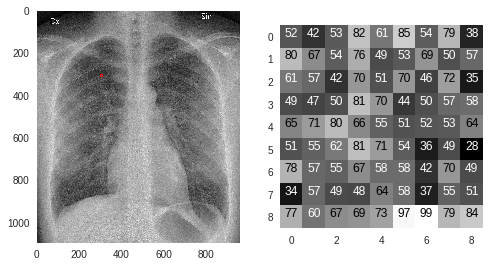

gaussian_blur


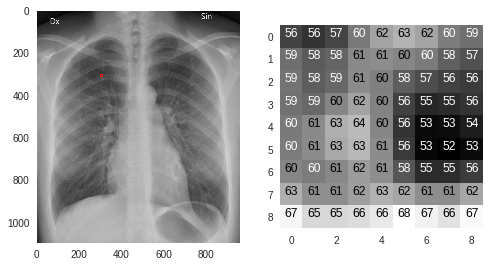

In [0]:
import numpy as np 

print('identity')
identity = np.array([[0, 0, 0], 
                     [0, 1, 0],
                     [0, 0, 0]])

show_image_with_patch(convolve2d(image, identity))

print('edge detection')
edge_detection = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])

show_image_with_patch(convolve2d(image, edge_detection), vmin=-255, vmax=255)

print('vertical edge detection')
vertical = np.array([[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]])

show_image_with_patch(convolve2d(image, vertical), vmin=-255, vmax=255)

print('horizontal edge detection')
horizontal = np.array([[1, 1, 1],
                       [0, 0, 0],
                       [-1, -1, -1]])

show_image_with_patch(convolve2d(image, horizontal), vmin=-255, vmax=255)

print('sharpen')
sharpen = np.array([[0, -1, 0], 
                    [-1, 5, -1],
                    [0, -1, 0]])

show_image_with_patch(convolve2d(image, sharpen), vmin=0, vmax=255)

print('gaussian_blur')
gaussian_blur = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) * (1./16.)

show_image_with_patch(convolve2d(image, gaussian_blur), vmin=0, vmax=255)

以上の結果から、畳み込みによって**エッジの検出**、**先鋭化**、**ぼかし**などの多様な画像変換が可能になることが確認できます。

## 深層畳み込みニューラルネットワークの基礎

深層畳み込みニューラルネットワークは、入力信号に対する畳み込みを行って**特徴マップ**（畳み込み処理後の画像）を出力する**畳み込み層**と、その**特徴マップ**における局所的なパターンを統合する**プーリング層**の組み合わせにより主に構成されます。

前章では、古典的な画像に対する畳み込み演算を概観しました。深層畳み込みニューラルネットワークの**学習**では、ネットワークからの出力と教師信号の誤差を評価する**損失関数**の値を最小化するための方向に、各畳込み層のカーネルの値が逆誤差伝播法により学習されます。すなわち、タスクに応じて最適なカーネルが自動的に獲得されるという仕組みを有し、これが<u>「人の手によらない特徴抽出を深層学習が可能にする」</u>と言われる所以です。

---

**注意** : 深層畳み込みニューラルネットワークについての概要については、数多くの分かりやすい説明があるため、適宜ご参考にして下さい。

参考 : https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

### ニューラルネットワークの構築

ここでは、**VGG16**と呼ばれる深層畳み込みニューラルネットワークを用いて、未学習のネットワークと学習済みのネットワークの内部構造について比較して考察してみたいと思います。

そのために、深層学習ライブラリである**pytorch**と、画像処理のためのライブラリである**torchvision**を利用します。

<u>今回の検討では、このVGG16において各層から抽出される特徴マップを可視化し、サンプル画像がこのネットワークの内部でどのように処理されているのかを考察することとします。</u> そのために、オリジナルのVGG16を継承した新しいクラスを作り、順方向の計算によって、**中間層の特徴マップを格納したリスト**が出力されるように設計し直します。このとき、プーリング層によって落とされた特徴マップの解像度を、元の解像度に一致させるためのアップサンプリング処理を`F.interpolate`により行います。

In [0]:
from collections import namedtuple

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import models


class Vgg16(nn.Module):
    def __init__(self, pretrained=False, requires_grad=False):

        super(Vgg16, self).__init__()
        pretrained = models.vgg16(pretrained=pretrained)
        vgg_pretrained_features = pretrained.features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()

        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = x.repeat((1, 3, 1, 1))
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h

        h_relu2_2 = F.interpolate(h_relu2_2, scale_factor=2)
        h_relu3_3 = F.interpolate(h_relu3_3, scale_factor=4)
        h_relu4_3 = F.interpolate(h_relu4_3, scale_factor=8)

        vgg_outputs = namedtuple(
            "VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        )
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

        return out



続いて、未学習のVGG16（`scratch`）と、ImageNetと呼ばれるデータセットにおいて学習済みのVGG16（`trained`）を用意します。



In [0]:
scratch = Vgg16(pretrained=False)
trained = Vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 66862717.10it/s]


ここで、`scratch`（あるいは`trained`）の`named_parameters`を呼び出すことによって、このネットワークの順方向の計算過程を次のように展開することが出来ます。上の`class`定義中の`forward`関数の中身と見比べながら、以下の黒字で示された各階層の最終層の`relu`の出力が、順番にリストに格納されて出力される設計になっていることを確認して下さい。


  (slice1): Sequential(  
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (1): ReLU(inplace)  
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (3): **ReLU(inplace)**  
  )  
  
  (slice2): Sequential(  
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (6): ReLU(inplace)  
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (8): **ReLU(inplace)**  
  )  
  
  (slice3): Sequential(  
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (11): ReLU(inplace)  
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (13): ReLU(inplace)  
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (15): **ReLU(inplace)**  
  )
  
  (slice4): Sequential(  
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (18): ReLU(inplace)  
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (20): ReLU(inplace)  
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (22): **ReLU(inplace)**  
  )  


### 畳み込み層のカーネルの学習前後での比較

それでは、VGG16の最初の畳み込み層（`slice1.Conv2d`）におけるカーネルについて、未学習のネットワーク`scratch`と学習済みのネットワーク`trained`とで比較します。出力される図表において、上段が`scratch`より得たカーネル（`s-1, s-2, ..., s-9`）、下段が`trained`より得たカーネル（`t-1, t-2, ..., t-9`）となります。学習によって、識別のタスクに対してより有用なカーネルが得られていることが期待されますが、例えばt-0やt-5はそれぞれ左右、上下といった方位選択的なフィルタになっていることが推察できます。

---

**注意** : 同様の検討をResNetの最初の$7 \times 7$の畳み込み層のカーネルで行うと、学習に伴うカーネルの構造的な変化がより直感的に分かりやすいかもしれません。

In [0]:
scratch_conv = scratch.slice1[0].weight
trained_conv = trained.slice1[0].weight

fig = plt.figure()

num = 10 
for i in range(num):
    ax = fig.add_subplot(2, num, i+1)
    scratch_img = scratch_conv[i, 0, :, :]
    ax.imshow(scratch_img)
    ax.tick_params(labelbottom=False, bottom=False)
    ax.tick_params(labelleft=False, left=False)
    ax.grid(False)
    ax.set_title('s-' + str(i))
    
    ax = fig.add_subplot(2, num, num + i + 1)
    trained_img = trained_conv[i, 0, :, :]
    ax.imshow(trained_img)
    ax.tick_params(labelbottom=False, bottom=False)
    ax.tick_params(labelleft=False, left=False)
    ax.grid(False)
    ax.set_title('t-' + str(i))

plt.show()